In [1]:
#python specific stuff
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from functions import *
from ReadInParameters import *

##TODO Lizzy
#variable time step? check convergence somehow? Runge kutta method
#optimize run time
#internal volumes
#different types of windows
#initial = external temp
#internals - end cell no heat loss
#underfloor heating
#hot spot with fixed temp (or ratio of temp to water system temp??)

#FOR DAD
# Check material values
# how to do windows double glazing
# make Qin model for different types of heating


In [2]:
## INITIALIZATION for time, and distance step?
total_time_h=0.5 #hours
t_step=1 #s
total_time_s=total_time_h*60*60
N_t_steps=int(total_time_s/t_step)
#cell_length=0.5 

In [3]:
# # UPPER ROOM INITIALIZATION #########################
[rooms,surfaces,T_target,T_exterior,hotspots,internals]=ReadInParameters('UserInputSheet.xlsx')
upper=rooms[0]
middle=rooms[1]
lower=rooms[2]
surface_array_upper=surfaces[0]
surface_array_middle=surfaces[1]
surface_array_lower=surfaces[2]

C:\Users\EH842\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [4]:
## DO CALCULATION ##################

data_array_T_room_upper=np.zeros(int(N_t_steps))
data_array_T_room_middle=np.zeros(int(N_t_steps))
data_array_T_room_lower=np.zeros(int(N_t_steps))
Qs=np.zeros(int(N_t_steps))
data_array_surfaces=np.zeros([int(N_t_steps),13])
data_array_surfaces_Q=np.zeros([int(N_t_steps),13])
data_array_hotspots=np.zeros([int(N_t_steps),3])
data_array_hotspots_Q=np.zeros([int(N_t_steps),3])
Qin_cumul=[0]


for t in tqdm(range(N_t_steps)):
    
    #input data into arrays for plotting
    data_array_T_room_upper[t]=upper.T_room
    data_array_T_room_middle[t]=middle.T_room
    data_array_T_room_lower[t]=lower.T_room
    
    data_array=[]  
    for surface in surface_array_upper+surface_array_middle+surface_array_lower+internals:
            data_array=np.append(data_array,surface.T_array[0])            
    data_array_surfaces[t,:]=data_array
    
    data_array=[]  
    for surface in surface_array_upper+surface_array_middle+surface_array_lower+internals:
            data_array=np.append(data_array,surface.Qout_array[0])            
    data_array_surfaces_Q[t,:]=data_array
    
    
    data_array=[]
    data_array_hotspot=[]
    for hotspot in hotspots:
            data_array=np.append(data_array,hotspot.T_array[0])            
    data_array_hotspots[t,:]=data_array
    
                      
    
    
    
    # #temp monitoring for heater switch on/off
    Qin_total=0
    if lower.T_room >= T_target:
        upper.Qin=0
        middle.Qin=0
        lower.Qin=0
        for surface in surface_array_upper+surface_array_middle+surface_array_lower+internals:
            surface.Qrad=0
    else:
        upper.Qin=upper.Qin_max
        middle.Qin=middle.Qin_max
        lower.Qin=lower.Qin_max
        Qin_total=Qin_total+upper.Qin+middle.Qin+lower.Qin
        for surface in surface_array_upper+surface_array_middle+surface_array_lower+internals:
            surface.Qrad=surface.Qrad_max
            Qin_total=Qin_total+surface.Qrad
    
    data_array=[]# for hotspots
    ## LAYER UPPER
    [Qout_room_total,surface_array_upper]=do_surfaces_in_room(surface_array_upper,upper.T_room,t_step,T_exterior)
    Qout_room_to_hotspot=do_hotspots_in_room(hotspots[0],t_step,T_exterior)
    data_array=np.append(data_array,Qout_room_to_hotspot)  
    [Qout_room_to_internals,internals[0]]=do_internals_in_room(internals[0],upper.T_room,t_step,T_exterior)
    Qout_upper_to_middle=calculate_Qout_convective(upper.U,upper.area,upper.T_room,middle.T_room)
    Q_leak_upper=upper.airchanges_per_hour*upper.volume*t_step*upper.densityC*(upper.T_room-T_exterior)/3600
    Qout_room_total=Qout_room_total+Qout_upper_to_middle+Qout_room_to_internals+Qout_room_to_hotspot+Q_leak_upper
    upper.T_room=upper.T_room+calculate_Tchange(upper.Qin,Qout_room_total,t_step,upper.densityC,upper.volume)
    
    ## LAYER MIDDLE
    [Qout_room_total,surface_array_middle]=do_surfaces_in_room(surface_array_middle,middle.T_room,t_step,T_exterior)
    Qout_room_to_hotspot=do_hotspots_in_room(hotspots[1],t_step,T_exterior)
    data_array=np.append(data_array,Qout_room_to_hotspot) 
    [Qout_room_to_internals,internals[1]]=do_internals_in_room(internals[1],middle.T_room,t_step,T_exterior)
    Qout_middle_to_lower=calculate_Qout_convective(middle.U,middle.area,middle.T_room,lower.T_room)
    Q_leak_middle=middle.airchanges_per_hour*middle.volume*t_step*middle.densityC*(middle.T_room-T_exterior)/3600
    Qout_room_total=Qout_room_total+Qout_middle_to_lower+Qout_room_to_internals+Qout_room_to_hotspot+Q_leak_middle
    middle.T_room=middle.T_room+calculate_Tchange(middle.Qin+Qout_upper_to_middle,Qout_room_total,t_step,middle.densityC,middle.volume)
    
    ## LAYER LOWER
    [Qout_room_total,surface_array_lower]=do_surfaces_in_room(surface_array_lower,lower.T_room,t_step,T_exterior)
    Qout_room_to_hotspot=do_hotspots_in_room(hotspots[2],t_step,T_exterior)
    data_array=np.append(data_array,Qout_room_to_hotspot) 
    [Qout_room_to_internals,internals[2]]=do_internals_in_room(internals[2],lower.T_room,t_step,T_exterior)
    Q_leak_lower=lower.airchanges_per_hour*lower.volume*t_step*lower.densityC*(lower.T_room-T_exterior)/3600
    Qout_room_total=Qout_room_total+ Qout_room_to_internals+Qout_room_to_hotspot+Q_leak_lower
    lower.T_room=lower.T_room+calculate_Tchange(lower.Qin+Qout_middle_to_lower,Qout_room_total,t_step,lower.densityC,lower.volume)
    
    data_array_hotspots_Q[t,:]=data_array
    
    ## CUMUL Q
    Qin_cumul=np.append(Qin_cumul,Qin_cumul[t]+Qin_total*t_step)  

100%|██████████| 1800/1800 [00:03<00:00, 567.44it/s]


7.564062067708282


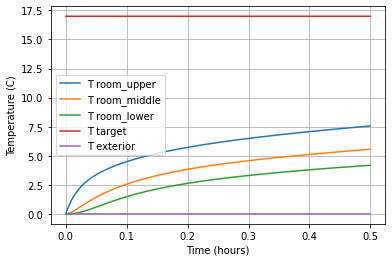

In [5]:
# MAKE PLOTS ##########################

t_array=np.arange(0,N_t_steps*t_step,t_step)/(60*60)
plt.plot(t_array,data_array_T_room_upper,label='T room_upper')
plt.plot(t_array,data_array_T_room_middle,label='T room_middle')
plt.plot(t_array,data_array_T_room_lower,label='T room_lower')
plt.plot(t_array,np.full(N_t_steps,T_target),label='T target')
plt.plot(t_array,np.full(N_t_steps,T_exterior),label='T exterior')
plt.legend()
plt.grid('True')
plt.xlabel('Time (hours)')
plt.ylabel('Temperature (C)')
print(data_array_T_room_upper[-1])

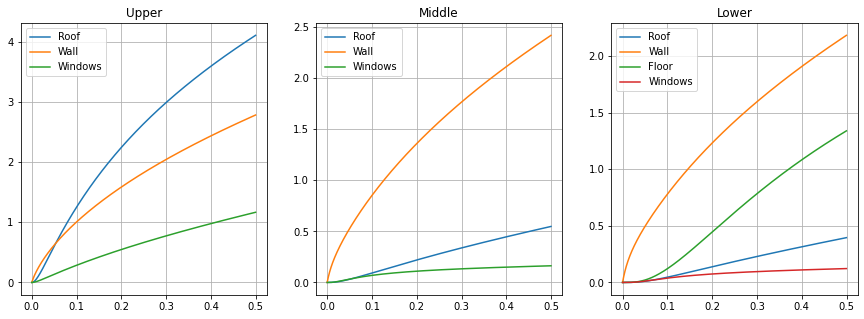

In [6]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15, 5))
lineObjects =ax1.plot(t_array,data_array_surfaces[:,0:3])
ax1.legend(iter(lineObjects), ('Roof','Wall','Windows'))
ax1.grid('True')
ax1.set_title('Upper')
lineObjects =ax2.plot(t_array,data_array_surfaces[:,3:6])
ax2.legend(iter(lineObjects), ('Roof','Wall','Windows'))
ax2.set_title('Middle')
ax2.grid('True')
lineObjects =ax3.plot(t_array,data_array_surfaces[:,6:10])
ax3.legend(iter(lineObjects), ('Roof','Wall','Floor','Windows'))
ax3.set_title('Lower')
ax3.grid('True')

Text(0.5, 1.0, 'Internals')

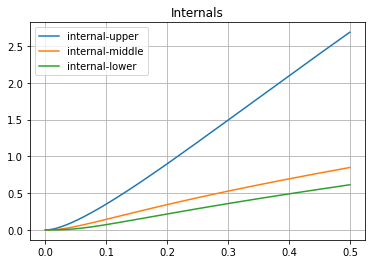

In [7]:
lineObjects =plt.plot(t_array,data_array_surfaces[:,10:13])
plt.legend(iter(lineObjects), ('internal-upper','internal-middle','internal-lower'))
plt.grid('True')
plt.title('Internals')

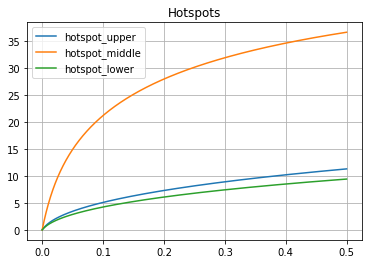

In [8]:
lineObjects =plt.plot(t_array,data_array_hotspots)
plt.legend(iter(lineObjects), ('hotspot_upper','hotspot_middle','hotspot_lower'))
plt.title('Hotspots')
plt.grid('True')

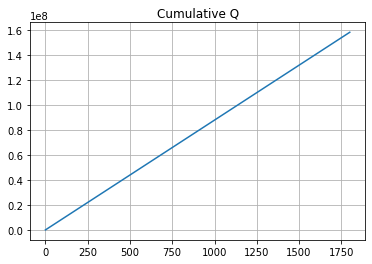

In [9]:
plt.plot(Qin_cumul)
plt.title('Cumulative Q')
plt.grid('True')

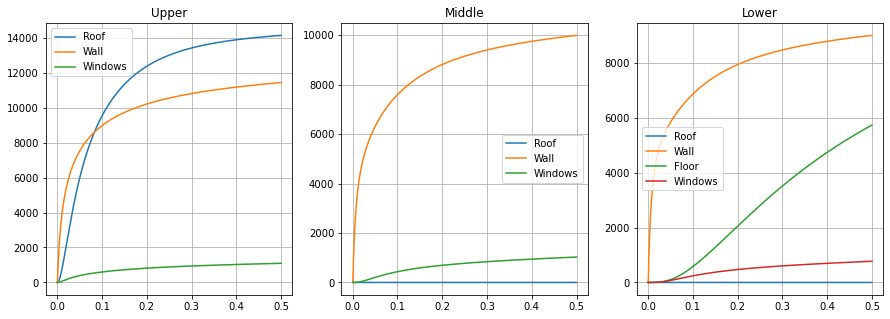

In [10]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15, 5))
lineObjects =ax1.plot(t_array,data_array_surfaces_Q[:,0:3])
ax1.legend(iter(lineObjects), ('Roof','Wall','Windows'))
ax1.grid('True')
ax1.set_title('Upper')
lineObjects =ax2.plot(t_array,data_array_surfaces_Q[:,3:6])
ax2.legend(iter(lineObjects), ('Roof','Wall','Windows'))
ax2.set_title('Middle')
ax2.grid('True')
lineObjects =ax3.plot(t_array,data_array_surfaces_Q[:,6:10])
ax3.legend(iter(lineObjects), ('Roof','Wall','Floor','Windows'))
ax3.set_title('Lower')
ax3.grid('True')

In [ ]:
lineObjects =plt.plot(t_array,data_array_surfaces_Q[:,10:13])
plt.legend(iter(lineObjects), ('internal-upper','internal-middle','internal-lower'))
plt.grid('True')
plt.title('Internals')

Text(0.5, 1.0, 'Internals')

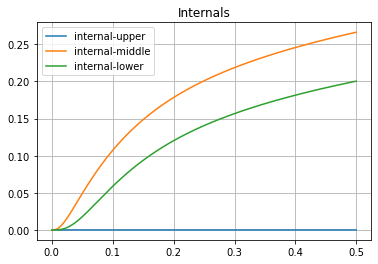

In [ ]:
lineObjects =plt.plot(t_array,data_array_hotspots)
plt.legend(iter(lineObjects), ('hotspot_upper','hotspot_middle','hotspot_lower'))
plt.title('Hotspots')
plt.grid('True')